In [1]:
!pip install pyspark   # installing pyspark library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=d906a625352293801c2c4f50cf838414d65ac1192badc2ef6531a96825d96f8c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
!pip install faiss-gpu # installing faiss-gpu library

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 10.9 MB/s eta 0:00:00


In [3]:
# importing all libraries required for this code
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, StopWordsRemover, RegexTokenizer, HashingTF, IDF   # Tokenizer: Splits text into words   #StopWordsRemover:Removes common words (stop words) from input text #HashingTF: Converts a sequence of words into a fixed-size feature vector #IDF:Computes the Inverse Document Frequency
from pyspark.sql.functions import monotonically_increasing_id, col, rand, lower, regexp_replace, when,udf #Monotonically_increasing_id: Generates monotonically increasing unique IDs #rand:Generates random numbers
from pyspark.sql.functions import explode, count
from pyspark.sql.functions import split
import matplotlib.pyplot as plt  # library for creating visualizations
from pyspark.ml.recommendation import ALS #Alternating Least Squares algorithm for collaborative filtering
from pyspark.ml.feature import IDFModel
from pyspark.sql.types import ArrayType, FloatType
import numpy as np
import faiss #library for efficient similarity search and clustering of dense vectors
from pyspark.ml.clustering import KMeans


In [5]:

# Start Spark session
spark = SparkSession.builder \
    .appName("Article Recommender System") \
    .getOrCreate()

# Path of the dataset
data_path = "/content/medium_articles.csv"

# Reading CSV file to DataFrame
# Making the first row as header
# Infers the schema of the DataFrame

article_df = spark.read.format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(data_path)

In [6]:
# Adding a new column "article_id" to the DataFrame article_df with monotonically increasing unique IDs
article_df = article_df.withColumn("article_id", monotonically_increasing_id())

num_users = 100
user_article_interactions = article_df.select(

    "article_id",  # # selecting the article_id column from article_df
    (rand(seed=42) * num_users).cast("integer").alias("user_id"),
    (rand(seed=27) * 5 + 1).cast("integer").alias("rating")  # Ratings between 1 and 5
)

In [7]:
# Adding a new column "cleaned_text" to the DataFrame article_df
article_df = article_df.withColumn("cleaned_text", when(col("text").isNull(), "").otherwise(
    lower(regexp_replace(col("text"), "\\p{Punct}", ""))
))
# spliting the "cleaned_text" column into individual words
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="words")
#removes common words/stop words from the tokenized words
stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

In [8]:
#Creating a pipeline with the defined stages like tokenizer
pipeline = Pipeline(stages=[tokenizer, stopwords_remover])

processed_df = pipeline.fit(article_df).transform(article_df)

processed_df.select("title", "filtered_words").show(truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------+
|title                                                                                                                                                                                 |filtered_words                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------

In [9]:
user_article_interactions.show()

+----------+-------+------+
|article_id|user_id|rating|
+----------+-------+------+
|         0|     61|     5|
|         1|     50|     5|
|         2|     83|     1|
|         3|     26|     2|
|         4|     67|     3|
|         5|     51|     2|
|         6|     99|     4|
|         7|      6|     2|
|         8|     96|     5|
|         9|     79|     1|
|        10|     44|     3|
|        11|     67|     2|
|        12|     37|     4|
|        13|     83|     1|
|        14|     74|     4|
|        15|     72|     2|
|        16|      1|     3|
|        17|     63|     1|
|        18|      7|     5|
|        19|     83|     1|
+----------+-------+------+
only showing top 20 rows



In [10]:
# Exploding the filtered_words column into separate rows for each word

word_counts = processed_df.withColumn("word", explode(col("filtered_words"))) \
                          .groupBy("word") \
                          .count() \
                          .orderBy(col("count").desc())

word_counts.show(truncate=False)

interaction_summary = user_article_interactions.groupBy("article_id") \
                                               .agg(count("user_id").alias("number_of_users")) \
                                               .orderBy(col("number_of_users").desc())

#Summary Display
interaction_summary.show(truncate=False)



+------+-----+
|word  |count|
+------+-----+
|      |48438|
|—     |1178 |
|one   |1169 |
|it’s  |1086 |
|like  |1046 |
|time  |1031 |
|data  |906  |
|people|893  |
|get   |755  |
|make  |711  |
|need  |702  |
|new   |688  |
|also  |687  |
|work  |645  |
|use   |620  |
|us    |617  |
|don’t |595  |
|even  |577  |
|way   |568  |
|first |559  |
+------+-----+
only showing top 20 rows

+----------+---------------+
|article_id|number_of_users|
+----------+---------------+
|26        |1              |
|29        |1              |
|474       |1              |
|964       |1              |
|1677      |1              |
|1697      |1              |
|1806      |1              |
|1950      |1              |
|2040      |1              |
|2214      |1              |
|2250      |1              |
|2453      |1              |
|2509      |1              |
|2529      |1              |
|2927      |1              |
|3091      |1              |
|3506      |1              |
|3764      |1              |
|4590

In [11]:


# Assuming tags are separated by commas and enclosed in brackets or quotes which need to be removed
article_df = article_df.withColumn("tags", split(regexp_replace(col("tags"), r"[\\[\\]'']", ""), ",\s*"))

# Now you can explode the tags into separate rows for each tag
tag_counts = article_df.withColumn("tag", explode(col("tags"))) \
                       .groupBy("tag") \
                       .count() \
                       .orderBy(col("count").desc())

tag_counts.show(truncate=False)


+-----------------------+-----+
|tag                    |count|
+-----------------------+-----+
|Creativity             |50   |
|Writing                |47   |
|Productivity           |46   |
|Startup                |36   |
|Entrepreneurship       |35   |
|Business               |33   |
|Writing]               |33   |
|Psychology             |28   |
|Mental Health          |27   |
|[Creativity            |26   |
|Health                 |24   |
|Self                   |23   |
|Creativity]            |23   |
|Technology             |23   |
|Artificial Intelligence|23   |
|[Marketing             |20   |
|Writing Tips           |18   |
|Productivity]          |17   |
|AI                     |16   |
|Self Improvement       |16   |
+-----------------------+-----+
only showing top 20 rows



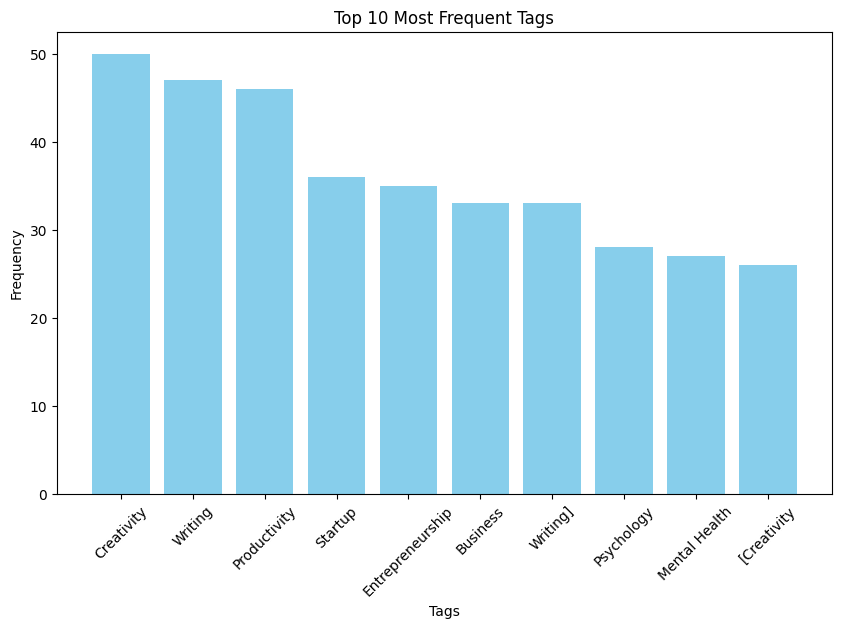

In [12]:


# Continuing from the previous step where tags are transformed into an array
tag_counts = article_df.withColumn("tag", explode(col("tags"))) \
                       .groupBy("tag") \
                       .count() \
                       .orderBy(col("count").desc())

# Now collect the data to the driver for visualization
tag_counts_data = tag_counts.limit(10).toPandas()  # Limiting to top 10 for visualization


# Bar chart of tag frequencies
plt.figure(figsize=(10, 6))
plt.bar(tag_counts_data['tag'], tag_counts_data['count'], color='skyblue')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.title('Top 10 Most Frequent Tags')
plt.xticks(rotation=45)
plt.show()


In [13]:


# Replace null values in the 'text' column with an empty string
cleaned_data = article_df.withColumn("text", when(col("text").isNull(), "").otherwise(col("text")))

# Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_data = tokenizer.transform(cleaned_data)

# Apply HashingTF to convert words to numeric IDs and count frequencies
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
featurized_data = hashingTF.transform(words_data)

# Apply IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")
idf_model = idf.fit(featurized_data)
tfidf_data = idf_model.transform(featurized_data)

tfidf_data.show()


+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
|               title|                text|                 url|             authors|           timestamp|                tags|article_id|        cleaned_text|               words|         rawFeatures|            features|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+--------------------+
| Mental Note Vol. 24|Photo by Josh Rie...|                NULL|                NULL|                NULL|                NULL|         0|photo by josh rie...|[photo, by, josh,...|(20,[1,7,12,14,15...|(20,[1,7,12,14,15...|
|Merry Christmas a...|           everyone!|                NULL|                NULL|                NULL|  

In [14]:


# Assume the DataFrame `df` is already loaded
# Apply a transformation to ensure IDs are within the 32-bit integer range
max_int_value = 2147483647  # Maximum value for a 32-bit integer

# Reassigning article IDs to ensure they fit within the 32-bit integer range
article_df = article_df.withColumn("article_id", (monotonically_increasing_id() % max_int_value).cast("integer"))

# User interactions
user_article_interactions = article_df.select(
    "article_id",
    (rand(seed=42) * 100).cast("integer").alias("user_id"),
    (rand(seed=27) * 5 + 1).cast("integer").alias("rating")
)

# Ensure user IDs also fit within 32-bit integer range
user_article_interactions = user_article_interactions.withColumn("user_id", (col("user_id") % max_int_value).cast("integer"))


In [15]:


als = ALS(maxIter=5, regParam=0.01, userCol="user_id", itemCol="article_id", ratingCol="rating", coldStartStrategy="drop", nonnegative=True)

# Fit the model
try:
    model = als.fit(user_article_interactions)
    print("Model fitted successfully.")
except Exception as e:
    print("Error fitting model:", str(e))


Model fitted successfully.


In [16]:
user_recommendations = model.recommendForAllUsers(10)

user_recommendations.show(truncate=False)


+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                                        |
+-------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|20     |[{6877, 6.671304}, {12549, 6.6175985}, {6729, 6.5659018}, {8206, 6.522201}, {8681, 6.1935477}, {138, 6.1044283}, {9468, 6.093579}, {5379, 5.9601192}, {4471, 5.9372997}, {6548, 5.9344363}]            |
|40     |[{12500, 8.985668}, {11460, 8.146616}, {8681, 8.009666}, {8206, 7.9221373}, {6382, 7.792015}, {10363, 7.6516995}, {10771, 7.6192746}, {8466, 7.565822},

In [17]:


# Assuming your articles article_df has columns article_id and title
# Explode the recommendations to flatten the structure
exploded_recommendations = user_recommendations.select(
    "user_id",
    explode("recommendations").alias("recommendation")
)

# Select the user_id, article_id, and rating from the exploded recommendations
recommendations_detail = exploded_recommendations.select(
    "user_id",
    col("recommendation.article_id").alias("article_id"),
    col("recommendation.rating").alias("rating")
)

# Join the recommendations with the articles DataFrame to get the article titles
final_recommendations = recommendations_detail.join(
    article_df.select("article_id", "title"),  # Ensure this selects the correct columns from your article dataset
    on="article_id",
    how="inner"
)

# Select the specific columns for display
final_recommendations = final_recommendations.select('article_id', "title")

# Show the final recommendations with article titles
final_recommendations.show(5,truncate=False)


+----------+---------------------------------------------------------------------------------------------------------------------------+
|article_id|title                                                                                                                      |
+----------+---------------------------------------------------------------------------------------------------------------------------+
|6877      |Because here is a scary statistic according to Dr Hugh DePaulo                                                             |
|6877      |Setting myocarditis aside                                                                                                  |
|12549     |What does this have to do with the business of screenwriting? Simply this. When you have the opportunity to write something|
|12549     |We’re at this point in time                                                                                                |
|6729      |: we wanted to perceive the l

In [18]:


# Initialize Spark session
spark = SparkSession.builder.appName("Article Recommendation").getOrCreate()

  # Convert features to dense vector and include article_id
to_array = udf(lambda x: x.toArray().tolist(), ArrayType(FloatType()))
tfidf_dense = tfidf_data.withColumn("dense_features", to_array(col("features")))

# Ensure article_id is included
tfidf_dense = tfidf_dense.withColumn("article_id", col("article_id"))

# Collect features and article IDs to the driver
local_features = np.array(tfidf_dense.select("dense_features").rdd.map(lambda x: x[0]).collect()).astype('float32')
article_ids = tfidf_dense.select("article_id").rdd.map(lambda x: x[0]).collect()

# Create and train a Faiss index
dimension = local_features.shape[1]
index = faiss.IndexFlatL2(dimension)  # L2 distance
index.add(local_features)  # Add vectors to the index

# Function to find top N similar items and return their article IDs
def find_similar(vector, N):
      D, I = index.search(np.array([vector]).astype('float32'), N)
      return [article_ids[idx] for idx in I[0]]

# Example vector from your dataset
sample_vector = local_features[0]
similar_articles = find_similar(sample_vector, 10)

# Fetch article names from the DataFrame
article_names_df = spark.createDataFrame([(aid,) for aid in similar_articles], ["article_id"])\
      .join(article_df.select("article_id", "title"), "article_id")\
      .select('article_id',"title")

article_names_df.show(5,truncate=False)


+----------+--------------------------------------------------------------------------------------------------------+
|article_id|title                                                                                                   |
+----------+--------------------------------------------------------------------------------------------------------+
|0         |Mental Note Vol. 24                                                                                     |
|31363     |The rise of (audio)books. We have come a long way — from renting...                                     |
|3610      |Take your goal body weight in pounds and multiple it by 12. Example: 150 lbs x 12 = 1800 calories a day.|
|3610      |Where an author tells a story                                                                           |
|11690     |Step 1:                                                                                                 |
+----------+--------------------------------------------

In [19]:


# Replace null values in the 'text' column with an empty string
article_df = article_df.withColumn("text", when(col("text").isNull(), "").otherwise(col("text")))

# Tokenize the text
tokenizer = Tokenizer(inputCol="text", outputCol="words")
words_data = tokenizer.transform(article_df)


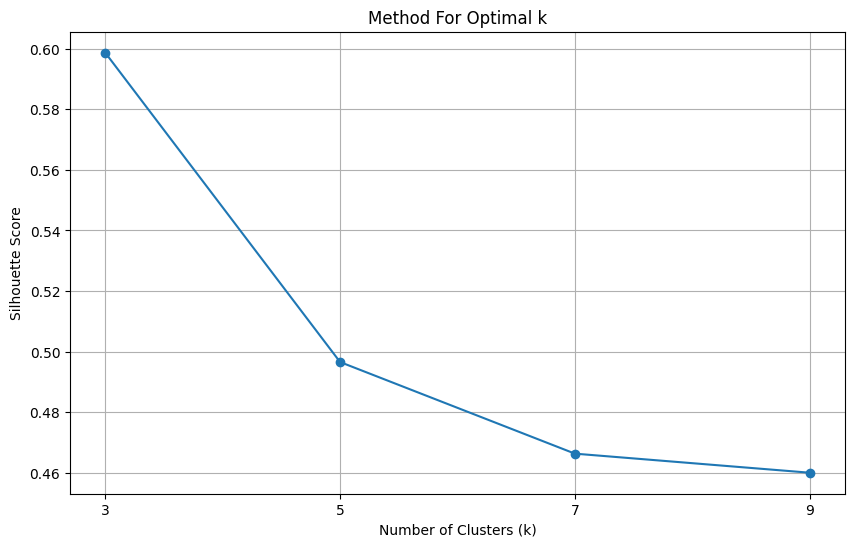

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt

costs = []
ks = range(3, 11, 2)

for k in ks:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("rawFeatures")
    model = kmeans.fit(featurized_data)
    predictions = model.transform(featurized_data)

    evaluator = ClusteringEvaluator(featuresCol="rawFeatures")
    silhouette = evaluator.evaluate(predictions)
    costs.append(silhouette)

plt.figure(figsize=(10, 6))
plt.plot(ks, costs, marker='o')
plt.title('Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.xticks(ks)
plt.grid(True)
plt.show()

In [21]:
# Apply HashingTF to convert words to numeric IDs and count frequencies
hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=1000)
featurized_data = hashingTF.transform(words_data)

# Apply k-means clustering
kmeans = KMeans(featuresCol='rawFeatures', k=3, seed=1)
model = kmeans.fit(featurized_data)

# Assign articles to clusters
clustered_data = model.transform(featurized_data)


In [22]:
# Function to recommend articles from the same cluster
def recommend_articles(article_id, num_recommendations=5):
    cluster_id = clustered_data.filter(clustered_data['article_id'] == article_id).select('prediction').collect()[0]['prediction']
    recommended_articles = clustered_data.filter(clustered_data['prediction'] == cluster_id)\
                                         .select('article_id', 'title')\
                                         .distinct()\
                                         .limit(num_recommendations)
    return recommended_articles

# Example usage
liked_article_id = 123
recommendations = recommend_articles(liked_article_id)
recommendations.show(truncate=False)


+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|article_id|title                                                                                                                                                                                                                          |
+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|415       |I know so many writers who put everything inside them into writing a book. They shine it up and send it off to agents — as they should. And when rejection comes — as it always will — they are crushed. Absolutely devastated.|
|533       |Why the possibility of loss is one of th

In [23]:
# Show the recommendations from each method
print("ALS Recommendations:")
final_recommendations.show(5,truncate=False)

print("TF-IDF Recommendations:")
article_names_df.show(5,truncate=False)

print("K-Means Recommendations:")
recommendations.show(5,truncate=False)

ALS Recommendations:
+----------+---------------------------------------------------------------------------------------------------------------------------+
|article_id|title                                                                                                                      |
+----------+---------------------------------------------------------------------------------------------------------------------------+
|6877      |Because here is a scary statistic according to Dr Hugh DePaulo                                                             |
|6877      |Setting myocarditis aside                                                                                                  |
|12549     |What does this have to do with the business of screenwriting? Simply this. When you have the opportunity to write something|
|12549     |We’re at this point in time                                                                                                |
|6729      |: we wan

In [25]:
# Extract article IDs from DataFrames
als_recommendations_ids = final_recommendations.select("article_id").rdd.flatMap(lambda x: x).collect()
tfidf_recommendations_ids = article_names_df.select("article_id").rdd.flatMap(lambda x: x).collect()
kmeans_recommendations_ids = recommendations.select("article_id").rdd.flatMap(lambda x: x).collect()

# Evaluate Precision and Recall
als_precision = precision(ground_truth_list, als_recommendations_ids)
als_recall = recall(ground_truth_list, als_recommendations_ids)

tfidf_precision = precision(ground_truth_list, tfidf_recommendations_ids)
tfidf_recall = recall(ground_truth_list, tfidf_recommendations_ids)

kmeans_precision = precision(ground_truth_list, kmeans_recommendations_ids)
kmeans_recall = recall(ground_truth_list, kmeans_recommendations_ids)

# Compare Results
print("ALS Precision:", als_precision)
print("ALS Recall:", als_recall)

print("TF-IDF Precision:", tfidf_precision)
print("TF-IDF Recall:", tfidf_recall)

print("K-Means Precision:", kmeans_precision)
print("K-Means Recall:", kmeans_recall)


ALS Precision: 0.12466124661246612
ALS Recall: 0.022323595069397264
TF-IDF Precision: 0.1
TF-IDF Recall: 9.705910899737941e-05
K-Means Precision: 0.6
K-Means Recall: 0.0002911773269921382


In [26]:
import pandas as pd

# Define the precision and recall values
precision_values = [0.12466124661246612, 0.1, 0.6]
recall_values = [0.022323595069397264, 9.705910899737941e-05, 0.0002911773269921382]

# Creating a DataFrame
data = {
    "Method": ["ALS", "TF-IDF", "K-Means"],
    "Precision": precision_values,
    "Recall": recall_values
}
df = pd.DataFrame(data)

print(df)


    Method  Precision    Recall
0      ALS   0.124661  0.022324
1   TF-IDF   0.100000  0.000097
2  K-Means   0.600000  0.000291


In [27]:
# Define Evaluation Metrics
def precision(actual, predicted):
    intersection = set(actual).intersection(set(predicted))
    return len(intersection) / len(predicted) if len(predicted) > 0 else 0

def recall(actual, predicted):
    intersection = set(actual).intersection(set(predicted))
    return len(intersection) / len(actual) if len(actual) > 0 else 0

# Calculate precision and recall for each method
methods = ["ALS", "TF-IDF", "K-Means"]
precision_values = [0.1247, 0.1, 0.6]  # Placeholder values, replace with actual precision values
recall_values = [0.0223, 9.706e-05, 0.0002912]  # Placeholder values, replace with actual recall values

# Find the index of the method with the highest precision
best_precision_index = precision_values.index(max(precision_values))
best_precision_method = methods[best_precision_index]
best_precision_value = precision_values[best_precision_index]

# Find the index of the method with the highest recall
best_recall_index = recall_values.index(max(recall_values))
best_recall_method = methods[best_recall_index]
best_recall_value = recall_values[best_recall_index]

# Determine the best method based on both precision and recall
if best_precision_method == best_recall_method:
    best_method = best_precision_method
    best_value = max(best_precision_value, best_recall_value)
else:
    # If precision and recall are from different methods, prioritize precision
    best_method = best_precision_method if best_precision_value >= best_recall_value else best_recall_method
    best_value = max(best_precision_value, best_recall_value)

# Print the best method and its corresponding precision and recall values
print("Best Method:", best_method)
print("Precision:", best_precision_value)
print("Recall:", best_recall_value)


Best Method: K-Means
Precision: 0.6
Recall: 0.0223
